# CS 455 Final Project - UG7
## Identifying AI-Generated Images using a Convolutional Neural Network (CNN)
Angelina Buysse, Austin Rollfing, Pranav Ramasahayam, William Reimer

Import need modules

In [11]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

Define commonly needed directories for datasets and device, optimally use cuda for efficiency.

In [12]:
TRAINING_DIR = os.path.join('input', 'train_data')
TRAINING_CSV_DIR = os.path.join('input', 'train.csv')
TESTING_DIR = os.path.join('input', 'test_data')
TESTING_CSV_DIR = os.path.join('input', 'test.csv')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Understand datasets

In [13]:
train_df = pd.read_csv(TRAINING_CSV_DIR, index_col=0)
train_df.info()
train_df

<class 'pandas.core.frame.DataFrame'>
Index: 74410 entries, 0 to 74409
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  74410 non-null  object
 1   label      74410 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


,file_name,label
0,train_data/056bbc0105c645a79a267146c0df2f2a.jpg,1
1,train_data/33774a669ad3428ea5982b3d35ae66c9.jpg,0
2,train_data/634bb95a786d4c67868f34d5ff2f2455.jpg,1
3,train_data/93565636d53845a8bcdc1e339aff3b95.jpg,0
4,train_data/18519cc98f834144a8be3ea6ea382e87.jpg,1
...,...,...
74405,train_data/9283b107f6274279b6f15bbe77c523aa.jpg,0
74406,train_data/4c6b17fe6dd743428a45773135a10508.jpg,1
74407,train_data/1ccbf96d04e342fd9f629ad55466b29e.jpg,0
74408,train_data/ff960b55f296445abb3c5f304b52e104.jpg,1


In [14]:
test_df = pd.read_csv(TESTING_CSV_DIR, index_col=0)
test_df.info()
test_df

<class 'pandas.core.frame.DataFrame'>
Index: 5540 entries, 0 to 5539
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  5540 non-null   object
 1   label      5540 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 129.8+ KB


,file_name,label
0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,train_data/041be3153810433ab146bc97d5af505c.jpg,0
2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0
4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1
...,...,...
5535,train_data/af80f6e69e7b4bd485b66ffbf360391c.jpg,0
5536,train_data/d287923ed7d14e488cc0565fbc1f4d7e.jpg,1
5537,train_data/12bac11d62f649869e971f534d7cf15e.jpg,0
5538,train_data/e423dbbcebf64c67bf04e98195061f45.jpg,1


Create dataset class base that will format the training and testing sets to be compatible with PyTorch

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, train = False, transform=None, download=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.download = download
        self.train = train

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img = self.img_labels.iloc[idx, 1].split('/')[1]
        img_path = os.path.join(self.img_dir, img)
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels.iloc[idx, 2]
        if self.transform:
            image = self.transform(image)
        return image, label

Creates the CNN model class that will be trained and tested

The kernal performs element-wise multiplication followed by summation which slides over the input image where each kernal detects a specific feature. Our kernal size of 3 is a 3x3 matrix that slides over the image.

The stride is a step size, where our step size of 1 means a filter move one pixel at a time. 

The padding adds zeros to the border of the image to ensure that the filters properly scan the entire image.

The forward funciton defines the forward pass of the neural network.

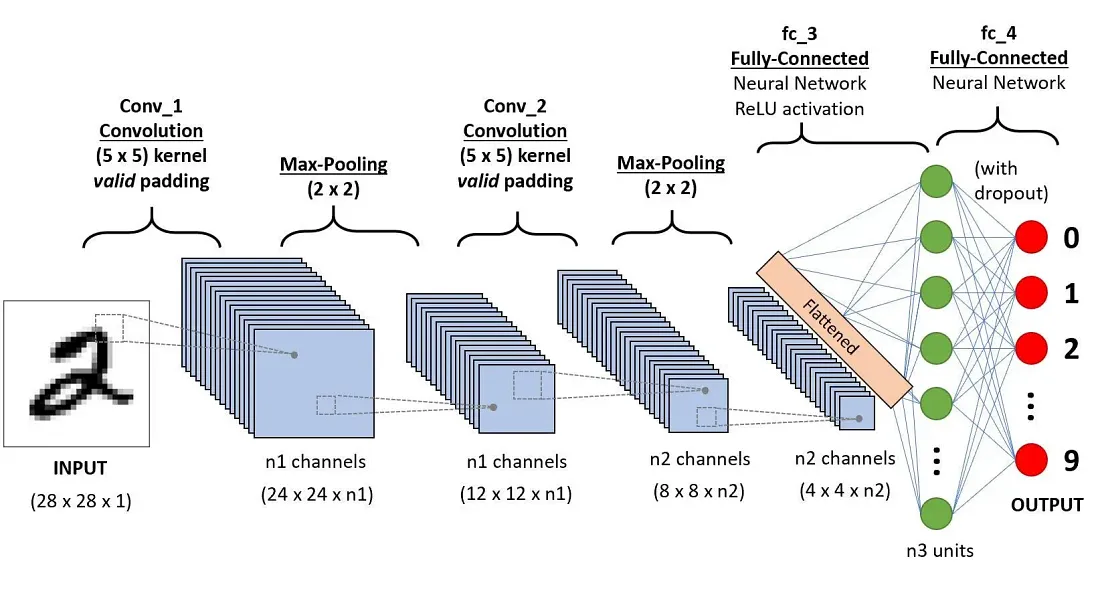
Source: https://medium.com/@myringoleMLGOD/simple-convolutional-neural-network-cnn-for-dummies-in-pytorch-a-step-by-step-guide-6f4109f6df80 

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,
                                out_channels=32,
                                kernel_size=3,
                                stride=1,
                                padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32,
                                out_channels=64,
                                kernel_size=3,
                                stride=1,
                                padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=64,
                                out_channels=128,
                                kernel_size=3,
                                stride=1,
                                padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(in_channels=128,
                                out_channels=256,
                                kernel_size=3,
                                stride=1,
                                padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        self.fc = nn.Linear(147456, 16)
        self.output = nn.Linear(16, 16)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.pool4(torch.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = self.output(torch.relu(self.fc(x)))
        nn.Softmax(x)
        return x

Create the model from the CNN class and attempt to connect model to Nvidia’s CUDA framework for accelerated training and iteration. The loss function is chosen as a Cross Entropy Loss, which adjusts weight of the model during training to minimize error.

In [17]:
model = CNN()
model.to(device)
loss_function = nn.CrossEntropyLoss()

# Check the device of the model
model_device = next(model.parameters()).device
print(f"Model is on device: {model_device}")

Model is on device: cuda:0


The batch size is set to 32, which is the number of samples processed in each iteration during training, to create a balance between memeory utilization and computational efficiency.

The datasets are transformed by resizing each image to the largest possible image size (768x768 pixels), reformatting into a tensor, and normalizing the tensor.

Each dataset is formatted into the Custom Image Dataset class base and that is used to format the Data Loader, which will handle our datasets during testing and training.

In [18]:
batch_size = 16
transform = transforms.Compose([
    transforms.Resize([384,384]),
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # Normalize to [0, 1]
])
train_dataset = CustomImageDataset(TRAINING_CSV_DIR, TRAINING_DIR, train=True, transform=transform,
download=True)
test_dataset = CustomImageDataset(TESTING_CSV_DIR, TESTING_DIR, train=False, transform=transform,
download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

Our optimizer is created to adjust the learning rate of each parameter to improve efficiency. 

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)

The model is trained and testing for each epoch, which is low for this model as each epoch takes around 3 hours to analyze. The model is trained and optimized and then tested. The results are displayed for every iteration.

In [ ]:
num_epochs=15
losses = []
testing_accuracies=[]
training_accuracies = []
for epoch in range(num_epochs):
    model.train()
    output_correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # Forward pass for both tasks
        output = model(images)
        
        # Calculate individual task losses
        output_loss = loss_function(output, labels)

        # Calculate output classification accuracy
        _, output = torch.max(output, 1)
        output_correct += (output == labels).sum().item()
        total += labels.size(0)

        # Backpropagation and optimization
        optimizer.zero_grad()
        output_loss.backward()
        optimizer.step()

    test_accuracy = 100 * output_correct / total
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {output_loss.item():.4f}')
    losses.append(output_loss.item())
    print(f"Epoch {epoch + 1} Training Classification Accuracy: {test_accuracy:.2f}%")
    training_accuracies.append(test_accuracy)

    output_correct, total = 0, 0
    predictions = []
    y_test = []
    accuracies = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            # Forward pass for both tasks
            output = model(images)

            # Calculate output classification accuracy
            _, output = torch.max(output, 1)
            output_correct += (output == labels).sum().item()

            total += labels.size(0)
            y_test.append(labels)
            predictions.append(output)
    test_accuracy = 100 * output_correct / total
    print(f"Epoch {epoch + 1} Testing Classification Accuracy: {test_accuracy:.2f}%")
    testing_accuracies.append(test_accuracy)
    accuracies.append(test_accuracy)

Epoch [1/15], Loss: 0.1566
Epoch 1 Training Classification Accuracy: 91.30%
Epoch 1 Testing Classification Accuracy: 95.72%
Epoch [2/15], Loss: 0.0024
Epoch 2 Training Classification Accuracy: 96.80%
Epoch 2 Testing Classification Accuracy: 97.96%
Epoch [3/15], Loss: 0.0272
Epoch 3 Training Classification Accuracy: 98.24%
Epoch 3 Testing Classification Accuracy: 98.39%
Epoch [4/15], Loss: 0.0047
Epoch 4 Training Classification Accuracy: 98.68%
Epoch 4 Testing Classification Accuracy: 98.27%
Epoch [5/15], Loss: 0.0037
Epoch 5 Training Classification Accuracy: 99.14%
Epoch 5 Testing Classification Accuracy: 98.81%
Epoch [6/15], Loss: 0.0030
Epoch 6 Training Classification Accuracy: 99.24%
Epoch 6 Testing Classification Accuracy: 98.43%
Epoch [7/15], Loss: 0.0231
Epoch 7 Training Classification Accuracy: 99.40%
Epoch 7 Testing Classification Accuracy: 98.88%
Epoch [8/15], Loss: 0.0141
Epoch 8 Training Classification Accuracy: 99.53%
Epoch 8 Testing Classification Accuracy: 98.94%
Epoch [9

The data collected during training and testing is exported to csv files.

In [21]:
losses_and_accuracies = pd.DataFrame({'losses': losses, 'train_accuracy': training_accuracies, 'test_accuracy': testing_accuracies})
losses_and_accuracies.to_csv(os.path.join('output', 'losses_and_accuracies.csv'))

test_vs_pred = pd.DataFrame({'y_test': torch.cat(y_test).cpu(), "predictions": torch.cat(predictions).cpu()})
test_vs_pred.to_csv(os.path.join('output', 'test_vs_pred.csv'))

A confusion matrix is used to visualize the model's accuracy.

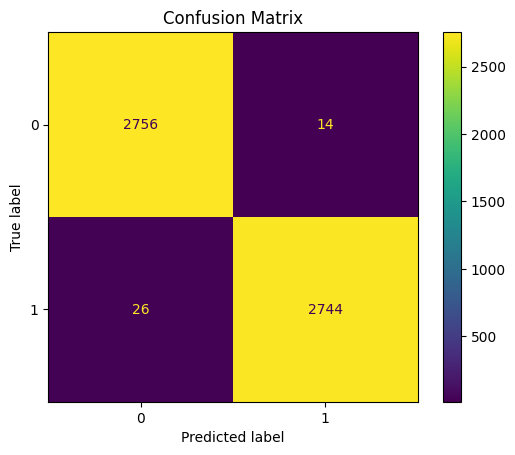

In [22]:
test_vs_pred = pd.read_csv(os.path.join('output', 'test_vs_pred.csv'))
cm = confusion_matrix(test_vs_pred['y_test'], test_vs_pred['predictions'])
ConfusionMatrixDisplay(cm).plot()
plt.title(f"Confusion Matrix")
plt.savefig(os.path.join('output', 'confusion_matrix.png'))
plt.show()

Two plots showing the progression or loss and accuracy are created for visualization.

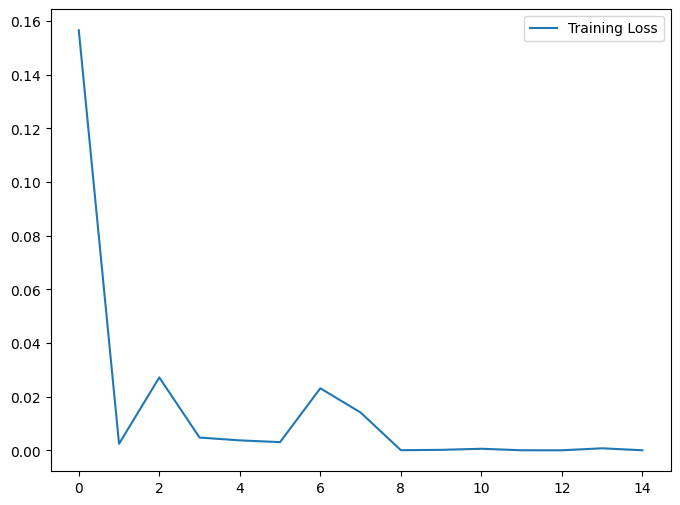

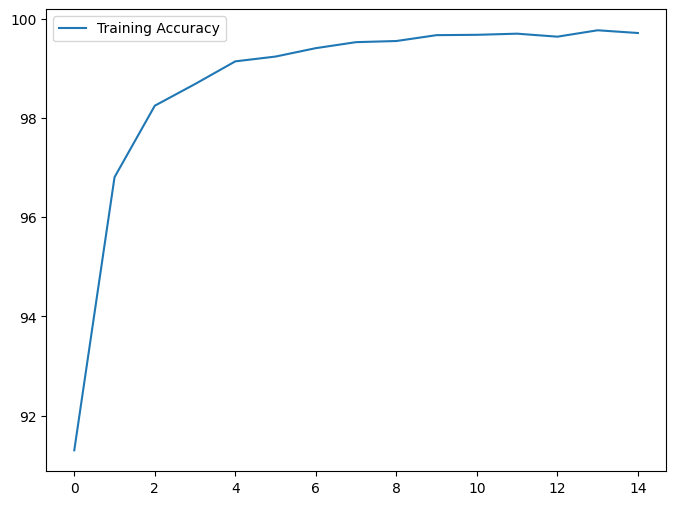

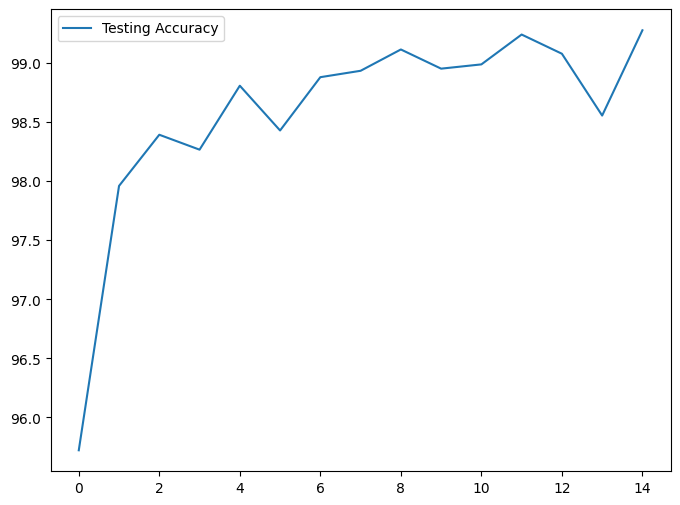

In [23]:
losses_and_accuracies = pd.read_csv(os.path.join('output', 'losses_and_accuracies.csv'))
plt.figure(figsize=(8, 6))
plt.plot(losses_and_accuracies['losses'], label='Training Loss')
plt.legend()
plt.savefig(os.path.join('output', 'training_loss.png'))
plt.show()
plt.figure(figsize=(8, 6))
plt.plot(losses_and_accuracies['train_accuracy'], label='Training Accuracy')
plt.legend()
plt.savefig(os.path.join('output', 'training_accuracy.png'))
plt.show()
plt.figure(figsize=(8, 6))
plt.plot(losses_and_accuracies['test_accuracy'], label='Testing Accuracy')
plt.legend()
plt.savefig(os.path.join('output', 'testing_accuracy.png'))
plt.show()

A plot showing an example of when the model correctly identified a real image is presented.

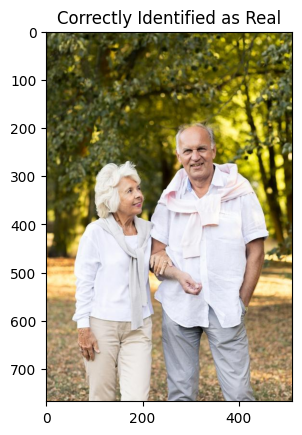

In [24]:
for i in range(len(test_vs_pred['y_test'])):
    if test_vs_pred['y_test'][i] == 0 and test_vs_pred['predictions'][i] == 0:
        img_file = pd.read_csv(TESTING_CSV_DIR).iloc[i, 1].split('/')[1]
        img = np.asarray(Image.open(os.path.join(TESTING_DIR, img_file)))
        plt.title("Correctly Identified as Real")
        plt.imshow(img)
        plt.savefig(os.path.join('output', 'Correctly_Identified_Real.png'))
        break     

A plot showing an example of when the model correctly identified an artificially generated image is presented.

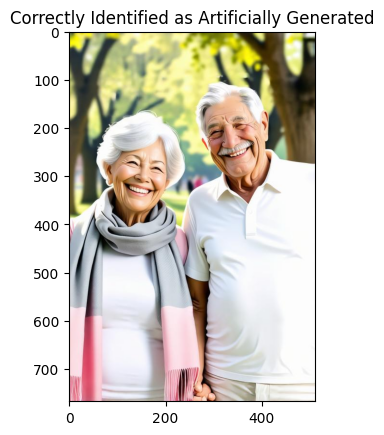

In [25]:
for i in range(len(test_vs_pred['y_test'])):
    if test_vs_pred['y_test'][i] == 1 and test_vs_pred['predictions'][i] == 1:
        img_file = pd.read_csv(TESTING_CSV_DIR).iloc[i, 1].split('/')[1]
        img = np.asarray(Image.open(os.path.join(TESTING_DIR, img_file)))
        plt.title("Correctly Identified as Artificially Generated")
        plt.imshow(img)
        plt.savefig(os.path.join('output', 'Correctly_Identified_AI.png'))
        break     

A plot showing an example of when the model incorrectly identified an image as real is presented.

c7f87020e0ac437e9bcc41042c82ce65.jpg


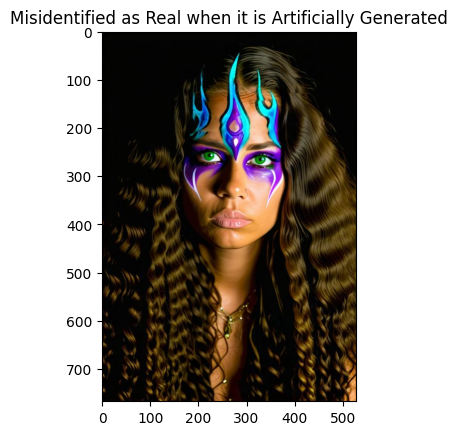

In [26]:
for i in range(len(test_vs_pred['y_test'])):
    if test_vs_pred['y_test'][i] == 1 and test_vs_pred['predictions'][i] == 0:
        img_file = pd.read_csv(TESTING_CSV_DIR).iloc[i, 1].split('/')[1]
        img = np.asarray(Image.open(os.path.join(TESTING_DIR, img_file)))
        print(img_file)
        plt.title("Misidentified as Real when it is Artificially Generated")
        plt.imshow(img)
        plt.savefig(os.path.join('output', 'Misidentified_Real.png'))
        break     

A plot showing an example of when the model incorrectly identified an image as artifically generated is presented.

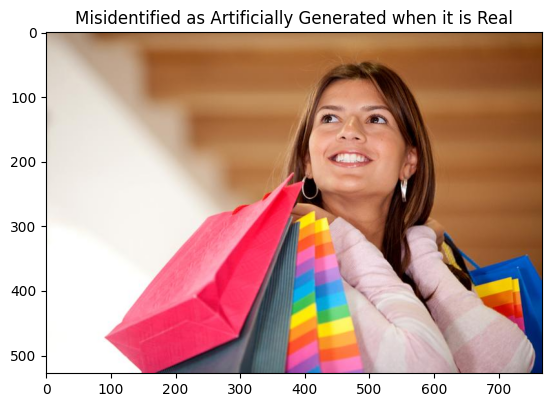

In [27]:
for i in range(len(test_vs_pred['y_test'])):
    if test_vs_pred['y_test'][i] == 0 and test_vs_pred['predictions'][i] == 1:
        img_file = pd.read_csv(TESTING_CSV_DIR).iloc[i, 1].split('/')[1]
        img = np.asarray(Image.open(os.path.join(TESTING_DIR, img_file)))
        plt.title("Misidentified as Artificially Generated when it is Real")
        plt.imshow(img)
        plt.savefig(os.path.join('output', 'Misidentified_AI.png'))
        break     